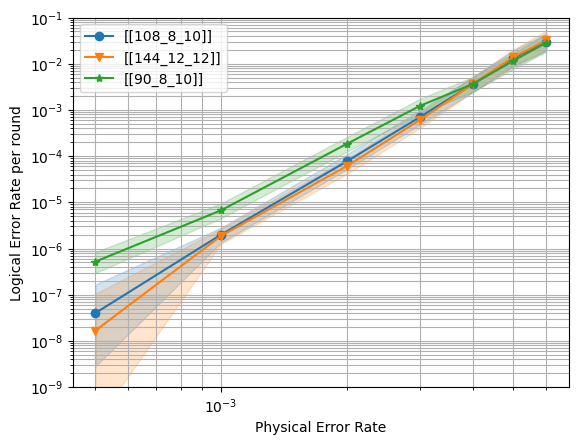

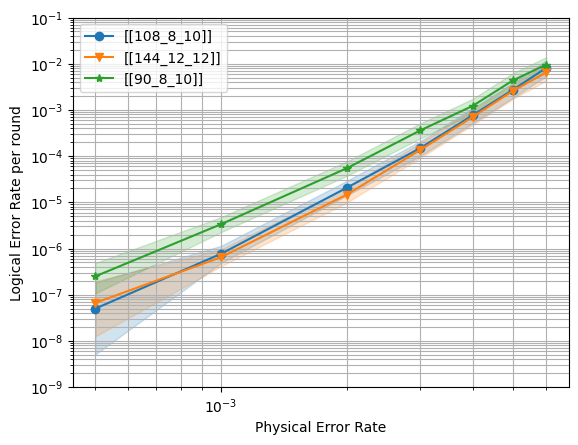

In [30]:
import matplotlib.pyplot as plt
import sinter 


collected_stats = sinter.stats_from_csv_files(f'../collected_stats/collected_stats_tham_modules_with_idling.csv', f'../collected_stats/collected_stats_tham_modules_zero_idling.csv')


for noise_model in ['tham_modules', 'tham_modules_zero_idling']:

    fig, ax = plt.subplots(1, 1)
    sinter.plot_error_rate(
        ax=ax,
        stats=collected_stats,
        x_func=lambda stats: stats.json_metadata['p'],
        group_func=lambda stats: stats.json_metadata['nkd'],
        failure_units_per_shot_func = lambda stats: stats.json_metadata['r'], # set as num_rounds ('r') failure units to find pL per round
        filter_func=lambda s: 
                s.json_metadata['nkd'] != f'[[120_8_8]]' and s.json_metadata['noise'] == noise_model
    )

    # ax.set_title(f"Tham modules noise")
    ax.loglog()
    ax.set_xlabel("Physical Error Rate")
    ax.set_ylabel("Logical Error Rate per round")
    ax.legend()
    ax.grid()
    ax.grid(True, which = 'minor')
    # fig.set_dpi(120)  # Show it bigger
    ax.set_ylim(1e-9, 1e-1)
    # ax.set_xlim(4e-4, 5e-3)
    # ax.figure.savefig(f"../plots/tham_modules_noise.png", dpi = 300, bbox_inches = "tight")
    ax.figure.savefig(f"../plots/scrap.png", dpi = 300, bbox_inches = "tight")

In [9]:
for stat in collected_stats:
    print(stat)

      3569,       102,         0,   102.5,bposd,cff1afba9ab6798eb14ea6bf641f48a7dc578f4c99c20e07b6decd3390faf50d,"{""A"":""'0001'"",""B"":""'002044'"",""b"":""Z"",""l"":6,""m"":10,""nkd"":""[[120_8_8]]"",""noise"":""tham_modules_zero_idling"",""p"":0.005,""r"":8}",
     52809,        63,         0,   437.3,bposd,e685e53a45dd8b0a82b318f6aaa4499c638becdb87005440c5ace1662c1a033a,"{""A"":""'0001'"",""B"":""'002044'"",""b"":""Z"",""l"":6,""m"":10,""nkd"":""[[120_8_8]]"",""noise"":""tham_modules_zero_idling"",""p"":0.002,""r"":8}",
     30545,         5,         0,   437.1,bposd,fa216e379a33495b0476ef475770477ce84c1cb2c68a565fd0e5aeb90805205d,"{""A"":""'300102'"",""B"":""'031020'"",""b"":""Z"",""l"":9,""m"":6,""nkd"":""[[108_8_10]]"",""noise"":""tham_modules_zero_idling"",""p"":0.002,""r"":10}",
      3737,       100,         0,   234.2,bposd,681406fe9b5cad25b47dee5f06eb6ad773fb74cc84761d2c16bc917e98d22ab9,"{""A"":""'300102'"",""B"":""'031020'"",""b"":""Z"",""l"":9,""m"":6,""nkd"":""[[108_8_